## 予測符号化による訓練
入出力を固定 (clamp) する．電位固定法のようなものか？predictive codingと文字を合わせる．(Song et al., 2023)

$x_0=s_{in}, x_{L+1}=s_{target}$とする．状態$x_l(t=0)=\mathbf{0} (l=2, \ldots, L)$に初期化する．予測誤差 $\mathbf{\epsilon}_l$ を次式で計算する．

$$
\begin{equation}
\mathbf{\epsilon}_l(t)=\mathbf{z}_l(t)-\mathbf{w}_{l-1}f(\mathbf{z}_{l-1}(t))\quad(l=1, \ldots, L)
\end{equation}
$$

次に状態 $\mathbf{z}_l(t)\ (t=0, \ldots, \mathcal{T}-1)$ を次式で更新する．

$$
\begin{equation}
\mathbf{z}_l(t+1)=\mathbf{z}_l(t)+\gamma (-\mathbf{\epsilon}_l + f'(\mathbf{z}_l(t))) \circ (\mathbf{w}_l^\top \mathbf{\epsilon}_{l+1}(t))
\end{equation}
$$

収束後，重みを次式で更新する．$n$を一つのsampleの番号として，

$$
\begin{equation}
\mathbf{w}_l(n+1)=\mathbf{w}_l(n)+\eta \mathbf{\epsilon}_l(\mathcal{T}) f(\mathbf{z}_l(\mathcal{T}))^\top
\end{equation}
$$

として重みを更新する．

In [1]:
using Base: @kwdef
using LinearAlgebra, Random, PyPlot, ProgressMeter
rc("axes.spines", top=false, right=false)

活性化関数 (activation function) の構造体を`ActivationFunction` と定義する．この構造体には`forward` と `backward`の2種類の関数フィールド (field; 構造体の要素のこと) を持たせておく．2種類の関数はそれぞれ順伝播時と逆伝播時に使用する．

In [2]:
struct ActivationFunction
    forward::Function   # function for forward propagation
    backward::Function  # function for back-propagation
end

また，次のコードにより，構造体のインスタンスを関数として使用できるようにしておく．これはcallable objectと呼ばれる．

In [3]:
(f::ActivationFunction)(x) = f.forward(x)

In [4]:
Sigmoid = ActivationFunction(
    x -> 1.0 ./ (1.0 .+ exp.(-x)),
    y -> y .* (1 .- y)
)

Tanh = ActivationFunction(
    x -> tanh.(x),
    y -> 1 .- y .^ 2
)

Relu = ActivationFunction(
    x -> max.(0, x),
    y -> y .> 0
)

Identity = ActivationFunction(
    x -> x, # or use `identity` function
    y -> fill!(similar(y), 1)
);

ニューラルネットワークのパラメータを保持する構造体を定義する．

In [5]:
abstract type NeuralNet end
(f::NeuralNet)(x) = forward!(f, x)

ニューラルネットワーク内の学習可能なパラメータ (learnable parameter) を保持する構造体を定義する．各パラメータはそれ自体の値 (value) と損失関数に対する勾配 (gradient) を持つ．

In [6]:
mutable struct Param
    v::Array
    grad::Array

    Param(value) = new(value, zero(value))
end

In [7]:
struct MLP <: NeuralNet
    L::Int # num. of layers
    W::Vector{Param}; #b::Vector{Param}   # weights and bias
    z::Vector{Array}; ϵ::Vector{Array}   # state of forward/backward activity
    f::Vector{ActivationFunction} # activation functions of layers

    function MLP(n_units::Vector{Int}; f_hid::ActivationFunction=Sigmoid, f_out::ActivationFunction=Identity)
        L = length(n_units) - 1
        # initialization of parameters
        #W = [Param(2 * (rand(n_units[l], n_units[l+1]) .- 0.5) * sqrt(6/n_units[l])) for l in 1:L] # He
        W = [Param(2 * (rand(n_units[l], n_units[l+1]) .- 0.5) * sqrt(6/(n_units[l]+n_units[l+1]))) for l in 1:L] # Xavier
        
        # initialization of forward / backward states
        z, ϵ = Vector{Array}(undef, L+1), Vector{Array}(undef, L)
        f = vcat([repeat([f_hid], L-1)..., f_out])
        new(L, W, z, ϵ, f)
    end
end

### 順伝播 (forward propagation)
$f(\cdot)$を活性化関数とする．順伝播(feedforward propagation)は以下のようになる．$(\ell=1,\ldots,L)$

$$
\begin{align}
\text{入力層 : }&\mathbf{z}_1=\mathbf{x}\\
\text{隠れ層 : }&\mathbf{a}_\ell=W_\ell \mathbf{z}_\ell +\mathbf{b}_\ell\\
&\mathbf{z}_{\ell+1}=f_\ell\left(\mathbf{a}_\ell\right)\\
\text{出力層 : }&\hat{\mathbf{y}}=\mathbf{z}_{L+1}
\end{align}
$$

## 予測符号化による訓練
入出力を固定 (clamp) する．電位固定法のようなものか？predictive codingと文字を合わせる．(Rosebvbaum 2022, Song et al., 2023)

Rosenbaum, R. (2022). On the relationship between predictive coding and backpropagation. PloS One, 17(3), e0266102.


固定点解析によりbackpropと同等であることがわかる．

$\mathbf{z}_1=\mathbf{x}_{\textrm{in}}, \mathbf{z}_{L+1}=\mathbf{x}_{\textrm{target}}$とする．状態$\mathbf{z}_\ell(t=0)=\mathbf{0}\ (\ell=2, \ldots, L)$に初期化する．予測誤差 $\boldsymbol{\epsilon}_\ell(t)$ を次式で計算する．

$$
\begin{equation}
\boldsymbol{\epsilon}_{\ell}(t)=\mathbf{z}_{\ell+1}(t)-\mathbf{W}_{\ell}f(\mathbf{z}_{\ell}(t))\quad(\ell=1, \ldots, L-1)
\end{equation}
$$

$$
\boldsymbol{\epsilon}_{L} = \frac{\partial \mathcal{L} (\mathbf{z}_{L+1}, \mathbf{x}_{\textrm{target}})}{\partial \mathbf{z}_{L+1}}
$$

次に状態 $\mathbf{z}_\ell(t)\quad (\ell=2, \ldots, L;\  t=0, \ldots, \mathcal{T}-1)$ を次式で更新する．

$$
\begin{equation}
\mathbf{z}_\ell(t+1)=\mathbf{z}_\ell(t)+\gamma (-\boldsymbol{\epsilon}_{\ell-1} + f'(\mathbf{z}_\ell(t))) \circ (\mathbf{w}_\ell^\top \boldsymbol{\epsilon}_{\ell}(t))
\end{equation}
$$

収束後，重みを次式で更新する．$n$を一つのsampleの番号として，

$$
\begin{equation}
\mathbf{w}_l(n+1)=\mathbf{w}_l(n)+\eta \mathbf{\epsilon}_l(\mathcal{T}) f(\mathbf{z}_l(\mathcal{T}))^\top
\end{equation}
$$

として重みを更新する．


fixed prediction assumptionという (Millidge etal., 2022. Rosebvbaum 2022) 修正もある．

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}}\\
\delta_L&:=\frac{\partial \mathcal{L}}{\partial \mathbf{a}_L}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}} \frac{\partial \mathbf{z}_{L+1}}{\partial \mathbf{a}_L}\\
\mathbf{\delta}_\ell&:=\frac{\partial \mathcal{L}}{\partial \mathbf{a}_{\ell}}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{\ell+1}} \frac{\partial \mathbf{z}_{\ell+1}}{\partial \mathbf{a}_\ell}\\
&=\left(\frac{\partial \mathcal{L}}{\partial \mathbf{a}_{\ell+1}}\frac{\partial \mathbf{a}_{\ell+1}}{\partial \mathbf{z}_{\ell+1}}\right)\frac{\partial \mathbf{z}_{\ell+1}}{\partial \mathbf{a}_{\ell}}\\
&={\mathbf{W}_{\ell+1}}^\top \delta_{\ell+1} \odot f_\ell^{\prime}\left(\mathbf{a}_{\ell}\right)\\
\frac{\partial \mathcal{L}}{\partial \mathbf{W}_\ell}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_\ell} \frac{\partial \mathbf{z}_\ell}{\partial \mathbf{a}_\ell} \frac{\partial \mathbf{a}_\ell}{\partial \mathbf{W}_\ell}=\delta_\ell \mathbf{z}_\ell^\top\\
\frac{\partial \mathcal{L}}{\partial \mathbf{b}_\ell}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_\ell} \frac{\partial \mathbf{z}_\ell}{\partial \mathbf{a}_\ell} \frac{\partial \mathbf{a}_\ell}{\partial \mathbf{b}_\ell}=\delta_\ell
\end{align}
$$

In [32]:
# forward computation of MLP (clamp out)
function forward!(mlp::MLP, x::Array, y::Array; n_max_step=100)
    (;L, f, W, z, ϵ) = mlp
    γ = 0.1
    n_batch = size(x)[1]

    # initialize states
    z[1] = x # input (n_batch x n_neurons)
    z[L+1] = y # output (n_batch x n_neurons)
    for l in 2:L
        z[l] = zeros(n_batch, size(W[l].v)[1])
    end
    z_tm1 = copy(z)
    for t in 1:n_max_step
        for l in 1:L
            ϵ[l] = z[l+1] - f[l](z[l]) * W[l].v #f[l](z[l] * W[l].v .+ b[l].v)
        end
        
        for l in L:-1:2
            z[l] += γ * (-ϵ[l-1] + f[l].backward(z[l])) .* (ϵ[l] * W[l].v')
        end
        z_diff = (z[2:L] - z_tm1[2:L])
        converged = all([maximum(abs.(zd)) < 1e-3 for zd in z_diff])
        if converged
            break
        end
    end
    return f[end](z[L+1]) # output
end

forward! (generic function with 1 method)

In [9]:
mlp = MLP([2, 32, 3], f_hid=Sigmoid, f_out=Sigmoid);#Softmax);

In [10]:
x = randn(10, 2);
y = randn(10, 3);

In [11]:
out = forward!(mlp, x, y); 

In [12]:
mlp.ϵ

2-element Vector{Array}:
 [0.06247835668561921 0.48145108849890694 … 0.002760571678546181 -0.28707999643238; 0.12668784615417314 0.4644978611544659 … 0.08578867860214859 -0.3123665755554967; … ; -0.05371244234945524 0.545806537847794 … -0.04014189317323605 -0.3944485096768227; 0.0496463675023168 0.3903455589353321 … 0.054883647419568304 -0.2617901455428352]
 [1.7423724442882396 -1.449271196767299 -1.4557427804494802; 1.3632884178889952 1.2555763220423117 -0.6418971592212155; … ; 2.4081582041377354 0.892746852880862 -0.32996134547733086; 0.38528974701162233 -0.9599964410067762 -0.23428989490488433]

In [13]:
function backward!(mlp::MLP)
    (;L, W, z, ϵ, f) = mlp
    n_batch = size(z[1])[1]
    # backprop
    for l in L:-1:1
        W[l].grad = f[l](z[l])' * ϵ[l] / n_batch
    end
end

backward! (generic function with 1 method)

In [14]:
backward!(mlp)

Softmaxのbackwardは基本的に使用しないため，適当に`identity`関数などを入れておく．

### オプティマイザ
abstract typeとして`Optimizer`タイプを作成する．

In [15]:
abstract type Optimizer end

In [16]:
# SGD optimizer
@kwdef struct SGD{FT} <: Optimizer
    lr::FT=1e-2 # learning rate
end

function optimizer_update!(param::Param, optimizer::SGD; weight_decay=0)
    (;lr) = optimizer
    if weight_decay > 0
        param.grad += weight_decay * param.v
    end
    param.v -= lr * param.grad
end

optimizer_update! (generic function with 1 method)

次に**Adam** {cite:p}`Kingma2014-fm` を実装する．

In [17]:
# Adam optimizer
@kwdef mutable struct Adam <: Optimizer
    lr=1e-4; β1=0.9; β2=0.999; ϵ=1e-8
    ms=Dict(); vs=Dict();
end

# Adam optimizer
function optimizer_update!(param::Param, optimizer::Adam; weight_decay=0)
    (;lr, β1, β2, ϵ, ms, vs) = optimizer
    key = objectid(param)
    if !haskey(ms, key) 
        ms[key], vs[key] = zero(param.v), zero(param.v)
    end
    if weight_decay > 0
        param.v -= lr * weight_decay * param.v
    end
    m, v = ms[key], vs[key]
    m += (1 - β1) * (param.grad - m)
    v += (1 - β2) * (param.grad .* param.grad - v)
    param.v -= lr * m ./ (sqrt.(v) .+ ϵ)
end

optimizer_update! (generic function with 2 methods)

重みのL2正則化 (Weight decay) を加える．正則化があることにより，実際のニューロンの活動を人工神経回路で再現できる研究も複数ある．バイアス項にはweight decayをしないため，optimizerの構造体の外からweight decayの値を与えることとする．

In [18]:
function optim_step!(nn::NeuralNet, optimizer::Optimizer; weight_decay=0)
    (;L, W) = nn
    # update weights
    for param in W
        optimizer_update!(param, optimizer, weight_decay=weight_decay)
    end
end

optim_step! (generic function with 1 method)

In [19]:
function train_step!(nn::NeuralNet, x::Array, y::Array; optimizer::Optimizer=SGD(), weight_decay=0)
    _ = forward!(nn, x, y)#nn(x, y)
    #loss = loss_fun(nn, y)
    backward!(nn)
    optim_step!(nn, optimizer, weight_decay=weight_decay) # update params
    #return loss
end

train_step! (generic function with 1 method)

### スパイラルデータセット
スパイラルデータセットは渦巻状をしており，$k$番目$(k=1, \ldots, K)$のクラスに属するサンプルは次の式で表される:

$$
\begin{align}
&\phi_k = \theta+\delta\theta+\frac{2\pi k}{K}\quad (\theta=[0, \pi])\ \\
&\mathbf{x}_k=[r\cos(\phi_k),\ r\sin(\phi_k)]\in \mathbb{R}^2\quad (r=[0, 1])
\end{align}
$$
ただし，$\theta/r=\pi$であり，$\delta\theta \sim \mathcal{N}(0, \sigma^2=0.2^2)$である．

In [20]:
function generate_spiral_dataset(num_classes=4, num_samples_per_class=100, dims=2, σ_θ=0.2)
    rs = range(0, 1, length=num_samples_per_class)
    θs = rs .* pi
    rotθ = 2pi / num_classes
    
    x_ = zeros(num_samples_per_class, num_classes, dims);
    for i in 1:num_classes
        δθ = randn(num_samples_per_class) * σ_θ
        ϕ = θs + δθ .+ (i-1) * rotθ
        x_[:, i, :] = rs .* [cos.(ϕ) sin.(ϕ)]
    end
    x = reshape(x_, (:, dims));
    t = repeat(1:num_classes, inner=(num_samples_per_class, 1)); # class label
    return x, vec(t)
end

generate_spiral_dataset (generic function with 5 methods)

In [21]:
n_classes = 4
x_train, t_train = generate_spiral_dataset(n_classes);

In [22]:
size(t_train)

(400,)

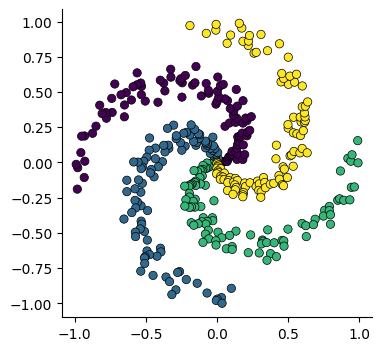

PyObject <matplotlib.collections.PathCollection object at 0x000002A3CCFDEE70>

In [23]:
figure(figsize=(4,4))
scatter(x_train[:, 1], x_train[:, 2], c=t_train, lw=0.5, ec="k")

In [24]:
# training θeter
n_traindata = size(x_train)[1]
n_batch = 10 # batch size
n_iter_per_epoch = round(Int, n_traindata/n_batch)
n_epoch = 100; # number of epoch

In [25]:
I_c = I(n_classes)

4×4 Diagonal{Bool, Vector{Bool}}:
 1  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅
 ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  1

In [26]:
y_train = 1.0*I_c[t_train, :];

In [36]:
nn1 = MLP([2, 32, n_classes], f_hid=Sigmoid, f_out=Sigmoid)#Softmax)
#loss_fun1 = cross_entropy_loss!

lr = 0.01#1e-3  # learning rate
weight_decay = 0 # weight decay (L2 norm) strength
optimizer1 = SGD(lr=lr)# Adam(lr=lr);

SGD{Float64}(0.01)

loss計算のlogを取る用の関数
biasの学習はprediction errorで引かれるので不要．

In [34]:
#error_arr = zeros(n_epoch); # memory array of each epoch error

@showprogress "Training..." for e in 1:n_epoch
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        x, y = x_train[idx, :], y_train[idx, :]
        train_step!(nn1, x, y, optimizer=optimizer1, weight_decay=weight_decay)
        #error_arr[e] += loss
    end 
    #error_arr[e] /= n_traindata
end

Training... 100%|████████████████████████████████████████| Time: 0:00:08


In [37]:
nn1.W[1]

Param([-0.13858178883290986 -0.35987012201104407 … 0.12438833308986667 -0.2737817758242198; 0.06213274483293911 0.20533138866207967 … -0.25641263459984304 0.299841816367172], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [ ]:
figure(figsize=(3,2))
semilogy(1:n_epoch, error_arr)
ylabel("Train loss"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

In [31]:
# forward computation of MLP (clamp out)
function forward2!(mlp::MLP, x::Array; n_max_step=50)
    (;L, f, W, z, ϵ) = mlp
    γ = 0.1
    n_batch = size(x)[1]

    # initialize states
    z[1] = x # input (n_batch x n_neurons)
    #z[L+1] = y # output (n_batch x n_neurons)
    for l in 2:L+1
        z[l] = zeros(n_batch, size(W[l].v)[1])
    end
    z_tm1 = copy(z)
    for t in 1:n_max_step
        for l in 1:L
            ϵ[l] = z[l+1] - f[l](z[l]) * W[l].v #f[l](z[l] * W[l].v .+ b[l].v)
        end
        
        for l in L:-1:2
            z[l] += γ * (-ϵ[l-1] + f[l].backward(z[l])) .* (ϵ[l] * W[l].v')
        end
        z_diff = (z[2:L] - z_tm1[2:L])
        converged = all([maximum(abs.(zd)) < 1e-3 for zd in z_diff])
        if converged
            break
        end
    end
    return f[end](z[L+1]) # output
end

forward2! (generic function with 1 method)

In [29]:
for l in 2:nn1.L+1
    println(size(nn1.W[l].v)[1])
end

32


LoadError: BoundsError: attempt to access 2-element Vector{Param} at index [3]

In [30]:
nn1.W[1]

Param([-Inf -Inf … -Inf -Inf; -Inf -Inf … -Inf -Inf], [Inf Inf … Inf Inf; Inf Inf … Inf Inf])

In [ ]:
x = -1.1:0.05:1.1
y = -1.1:0.05:1.1
X = ones(length(x)) * x'
Y = y * ones(length(y))'

x_test = Matrix(hcat([[xx, yy] for xx in x for yy in y]...)')
y_pred = forward!(nn1, x_test)
t_pred = 1.0*vec([inds[2] for inds in argmax(y_pred, dims=2)]);
T = reshape(t_pred, (length(x), length(y)))

LoadError: BoundsError: attempt to access 2-element Vector{Param} at index [3]

In [ ]:
figure(figsize=(4,4))
contourf(X, Y, T, alpha=0.8)
scatter(x_train[:, 1], x_train[:, 2], c=t_train, lw=0.5, ec="k", label="train data")
legend()

## 参考文献
```{bibliography}
:filter: docname in docnames
```